## Learning the micro-scale dynamics

This notebook aims to demonstrate the learning process and prediction for the *micro-scale* time evolution of the coupled physical fields $(T, P, \mu)$ involved in shock-induced energy localization in porous energetic material. We start by learning a *decoupled* latent representation of the dynamics of each physical field. It is encapsulated into a `MicroDynamicsDecoupled` model which consist of a variational autoencoder (VAE) together with a latent autoregressive functional to learn the induced dynamics over the latent space. In the next step, the *coupling* between the three physical fields $(T, P, \mu)$ is taken into account by training a `MicroDynamicsCoupledEfficient` model which is based on the three VAEs and decoupled latent autoregressive functionals learned in the previous step.  

The notebook primarily covers three sections:
- preparing the micro-scale data in appropriate format
- training the decoupled and coupled micro-dynamics models
- predicted evolution of the physical fields and corresponding latent fields over the latent space

In [1]:
import numpy as np
import tensorflow as tf
import os
import sys
import pickle 
import matplotlib.pyplot as plt

2025-05-26 09:34:22.710842: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 09:34:22.756961: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 09:34:23.101879: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-26 09:34:23.103526: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-26 09:34:23.918590: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

### Loading pre-processed data

The micro-scale simulation data consist of snapshots from time evolution of temperature $T$, pressure $P$ and microstructural morphology $\mu$ fields corresponding to a single-pore collapse in porous energetic material. The values of each physical field is normalized to the interval $ [0,1] $. The spatial size, i.e. input-height and input-width, of the snapshots is cropped to a multiple of $ 2^5 $ to be compatible with the architecture of the VAE and the latent dynamics autoregressive functionals. The temporal snapshots of physical fields are concatenated into a Numpy array `evolving_3fields_traj.npy` of shape (samples, input-height, input-width, physical fields, time-steps).

In addition, the corresponding VAE-encoded latent mean fields $\bar{Z}$ and latent log-variance fields $Z^\sigma$ are concatenated into Numpy arrays `encoded_latent_mean_fields_traj.npy` and `encoded_latent_var_fields_traj.npy`, respectively, of the shape (samples, latent-height, latent-width, latent fields, time-steps).

In [ ]:
base_dir = '/home/user/Multiscale-Latent-Dynamics'   # replace with your path
data_dir = os.path.join( base_dir, 'processed_data/micro_scale' ) 

In [ ]:
state_traj = np.load(os.path.join(data_dir, 'evolving_3fields_traj.npy'))
state_traj.shape

(238, 160, 256, 3, 20)

In [ ]:
latent_mean_traj = np.load( os.path.join( data_dir, "encoded_latent_mean_fields_traj.npy" ) )
latent_var_traj = np.load( os.path.join( data_dir, "encoded_latent_var_fields_traj.npy" ) )
print((latent_mean_traj.shape, latent_var_traj.shape))

((238, 20, 32, 12, 20), (238, 20, 32, 12, 20))


### Training the decoupled micro-scale latent dynamics model `MicroDynamicsDecoupled`

One should train one copy of `MicroDynamicsDecoupled` for each physical field $F \in \{ T, P, \mu \}$. Training the model follows a *curriculum learning* strategy in which the predicted time-horizon $ts$ increase successively. To this end, the full trajectory of evolution of each physical field $F \in \{ T, P, \mu \}$ is formatted into a `tf.dataset` of pairs of the form (input, output) in which:
- input = temporal snapshot of the physical field $F$ at time $t_i$
- output = temporal snapshots of the physical field $F$ corresponding to the next $ts$ time-steps, i.e. $t \in \{ t_{i+1}, \cdots , t_{i+ ts} \}$

In [ ]:
# local modules
module_dir = os.path.join( base_dir, 'Multiscale-Latent-Dynamics' ) 
sys.path.append(module_dir)
from models.micro_dynamics_decoupled import MicroDynamicsDecoupled
from models.micro_dynamics_coupled_efficient import MicroDynamicsCoupledEfficient
from utils.train_utils import in_out_latent_dataset, in_out_dataset, CheckPoint
from utils.dir_hyper import dyn_dir, mkdir_ifnot
from utils.visualization import plot_pred_field

In [ ]:
n_epoch_list = [2, 2]   # number of epochs
lr_list = [1e-4, 1e-4]   # learning rates 
bs = 1   # batch size

fields = ['temperature', 'pressure', 'microstructure']   # list of all physical fields
field_idx = 0   # the index of the chosen physical field F
field_indices = [0]   # list containing the chosen field_idx
output_fields=[(field_idx, fields[field_idx]) for field_idx in field_indices]

dynamics_model = 'unet'   # architecture of latent dynamics autoregressive functionals
dir = f"{dyn_dir(dynamics_model)['micro_dyn']['decoupled'][fields[field_idx]]}"  # directory for loading and saving the weights of micro-scale autoregressive functionals

for ts_idx in range(0, 2):
    # prepare batched tf.dataset for curriculum training
    train_data = in_out_dataset(state_traj, sample_range=[0, 190], n_ts=ts_idx+1, 
                                batch_size=bs, decoupled=True, field_idx=field_idx)

    val_data = in_out_dataset(state_traj, sample_range=[190, 200], n_ts=ts_idx+1, 
                            batch_size=bs, decoupled=True, field_idx=field_idx) 

    # initialize the decoupled micro-scale model corresponding to each physical field
    tf.keras.backend.clear_session()
    micro_dynamics_decoupled = MicroDynamicsDecoupled(ts = ts_idx + 1, 
                                                    fields = [fields[field_idx]], 
                                                    output_fields = output_fields, 
                                                    input_shape = (160, 256, 3), 
                                                    loss_weights = [1., 1., 1., 1., 1.],
                                                    dynamics_model=dynamics_model)

    if ts_idx > 0:   # load weights corresponding to the previous time horizon

        # Call model on a sample to create the model's variables before being able to load the weights
        init_x_gt = state_traj[0:1, :,:, field_idx:field_idx+1, 0:1]
        input = [init_x_gt, 1, output_fields]
        micro_dynamics_decoupled.call(input)
        
        prev_weight_dir = os.path.join(dir, f'test/{ts_idx}_ts')
        micro_dynamics_decoupled.load_weight(ts_idx, n_epoch_list[ts_idx-1], prev_weight_dir)

    # build and train the model
    micro_dynamics_decoupled.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_list[ts_idx], beta_1=0.5, beta_2=0.99))
    current_weight_dir = os.path.join(dir, f'test/{ts_idx+1}_ts')
    mkdir_ifnot(current_weight_dir)
    callback = CheckPoint(current_weight_dir, ckpt_period=20, spatial_scale='micro')                       
    history = micro_dynamics_decoupled.fit(train_data, epochs=n_epoch_list[ts_idx], callbacks=[callback], validation_data=val_data)
    micro_dynamics_decoupled.save_weight(ts_idx+1, n_epoch_list[ts_idx], current_weight_dir)
    with open(os.path.join(current_weight_dir, f'loss_history_{ts_idx+1}_ts.pkl'), 'wb') as file:
        pickle.dump(history.history, file)

2025-05-26 09:38:24.143469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-26 09:38:24.143715: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/2
19/19 [==============================] - 20s 763ms/step - total_loss: 0.8005 - consistency_mean_loss: 0.2583 - consistency_var_loss: 0.2520 - multi_step_loss: 0.2902 - val_total_loss: 0.7988 - val_consistency_mean_loss: 0.2575 - val_consistency_var_loss: 0.2520 - val_multi_step_loss: 0.2894
Epoch 2/2
19/19 [==============================] - 15s 816ms/step - total_loss: 0.7986 - consistency_mean_loss: 0.2565 - consistency_var_loss: 0.2520 - multi_step_loss: 0.2900 - val_total_loss: 0.7940 - val_consistency_mean_loss: 0.2526 - val_consistency_var_loss: 0.2520 - val_multi_step_loss: 0.2894
Epoch 1/2
18/18 [==============================] - 29s 1s/step - total_loss: 1.5661 - consistency_mean_loss: 0.4980 - consistency_var_loss: 0.5039 - multi_step_loss: 0.5642 - val_total_loss: 1.5450 - val_consistency_mean_loss: 0.4721 - val_consistency_var_loss: 0.5038 - val_multi_step_loss: 0.5690
Epoch 2/2
18/18 [==============================] - 20s 1s/step - total_loss: 1.5196 - consistency

### Training the coupled micro-scale latent dynamics model `MicroDynamicsCoupledEfficient`

In order to improve the memory efficiency of the training process, each physical field $F \in \{ T, P, \mu \}$ is first encoded into the latent space. The model learns the coupled micro-scale dynamics of all three fields over the latent space, and the corresponding reconstructed trajectory into the input space is compared with the ground truth.

Training the model follows a *curriculum learning* strategy in which the predicted time-horizon $ts$ increase successively. To this end, the full trajectory of the VAE-encoded latent fields $(\bar{Z}_F, Z_F^\sigma)$ and physical fields $(T, P, \mu)$ is formatted into a `tf.dataset` of pairs of the form (input, output) in which:
- input = temporal snapshot of latent fields $(\bar{Z}_F, Z_F^\sigma)$ at time $t_i$
- output = temporal snapshots of latent fields $(\bar{Z}_F, Z_F^\sigma)$ and physical fields $(T, P, \mu)$ corresponding to the next $ts$ time-steps, i.e. $t \in \{ t_{i+1}, \cdots , t_{i+ ts} \}$

In [ ]:
n_epoch_list = [2, 2]   # number of epochs
lr_list = [1e-4, 1e-4]   # learning rates 
bs = 1   # batch size

fields = ['temperature', 'pressure', 'microstructure'] # list of all physical fields
field_indices = [0, 1, 2]   # list of indices of all the coupled physical fields
output_fields=[(field_idx, fields[field_idx]) for field_idx in field_indices]

dynamics_model = 'unet'   # architecture of latent dynamics autoregressive functionals
dir = f"{dyn_dir(dynamics_model)['micro_dyn']['coupled']}"   # directory for loading and saving the weights of micro-scale autoregressive functionals

for ts_idx in range(0, 2):
    # prepare batched tf.dataset for curriculum training
    train_data = in_out_latent_dataset(latent_mean_traj, latent_var_traj, state_traj,
                                    sample_range=[0, 1], n_ts=ts_idx+1, batch_size=bs, field_indices=field_indices)

    val_data = in_out_latent_dataset(latent_mean_traj, latent_var_traj, state_traj,
                                    sample_range=[1, 2], n_ts=ts_idx+1, batch_size=bs, field_indices=field_indices)

    tf.keras.backend.clear_session()
    micro_dynamics_coupled_efficient = MicroDynamicsCoupledEfficient(ts=ts_idx + 1,
                                                                    fields = fields,
                                                                    output_fields=output_fields,
                                                                    latent_shape=(20, 32, 4),
                                                                    loss_weights=[1, 1, 1],
                                                                    dynamics_model=dynamics_model)
                                                    
    # call model on a sample to create the model's variables before being able to load the weights
    init_z_mean = latent_mean_traj[0:1, :,:,:, 0:1]
    init_z_var = latent_var_traj[0:1, :,:,:, 0:1]
    input = [init_z_mean, init_z_var, 1, output_fields]
    micro_dynamics_coupled_efficient.call(input)
    
    # load weights corresponding to the decoupled evolution of fields at micro-scale
    micro_dynamics_coupled_efficient.load_micro_decoupled_evol(pretrain_ts=[0, 0, 0], n_epochs=[0, 0, 0])

    if ts_idx > 0:   # load weights corresponding to the previous time horizon 
        prev_weight_dir = os.path.join(dir, f"test/{ts_idx}_ts")
        micro_dynamics_coupled_efficient.load_weight(ts_idx, n_epoch_list[ts_idx-1], prev_weight_dir) 

    # build and train the model
    micro_dynamics_coupled_efficient.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr_list[ts_idx], beta_1=0.5, beta_2=0.99))
    current_weight_dir = os.path.join(dir, f"test/{ts_idx+1}_ts")
    mkdir_ifnot(current_weight_dir)
    callback = CheckPoint(current_weight_dir, ckpt_period=20, spatial_scale='micro')                       
    history = micro_dynamics_coupled_efficient.fit(train_data, epochs=n_epoch_list[ts_idx], callbacks=[callback], validation_data=val_data)
    micro_dynamics_coupled_efficient.save_weight(ts_idx+1, n_epoch_list[ts_idx], current_weight_dir)
    with open(os.path.join(current_weight_dir, f'loss_history_{ts_idx+1}_ts.pkl'), 'wb') as file:
        pickle.dump(history.history, file)

Epoch 1/2
19/19 [==============================] - 47s 2s/step - total_loss: 2.3041 - consistency_mean_loss: 0.7430 - consistency_var_loss: 0.7434 - multi_step_loss: 0.8177 - val_total_loss: 2.1248 - val_consistency_mean_loss: 0.6467 - val_consistency_var_loss: 0.6612 - val_multi_step_loss: 0.8170
Epoch 2/2
19/19 [==============================] - 37s 2s/step - total_loss: 2.0795 - consistency_mean_loss: 0.6327 - consistency_var_loss: 0.6418 - multi_step_loss: 0.8051 - val_total_loss: 2.0236 - val_consistency_mean_loss: 0.6166 - val_consistency_var_loss: 0.6080 - val_multi_step_loss: 0.7990
Epoch 1/2
18/18 [==============================] - 71s 3s/step - total_loss: 4.0341 - consistency_mean_loss: 1.2524 - consistency_var_loss: 1.1990 - multi_step_loss: 1.5827 - val_total_loss: 3.8588 - val_consistency_mean_loss: 1.2225 - val_consistency_var_loss: 1.0647 - val_multi_step_loss: 1.5716
Epoch 2/2
18/18 [==============================] - 57s 3s/step - total_loss: 3.7972 - consistency_mean_

### Predicted evolution of physical fields and the corresponding latent fields

The micro-scale dynamics model `MicroDynamicsCoupledEfficient` can predict the time evolution of each physical field $F \in \{ T, P, \mu \}$ in the input space which correspond to micro-scale single-pore collapse in shock-loaded porous energetic material. The predicted evolution in the input space is based on the predicted trajectory of the corresponding latent fields $(\bar{Z}_F, Z_F^\sigma)$ inside the latent space and decoding it back into the input space. 

In [ ]:
# loading the weights of the full micro-scale dynamics model

fields = ['temperature', 'pressure', 'microstructure']   # list of all physical fields
field_indices = [0, 1]   # list of indices of the chosen physical fields to be predicted
output_fields=[(field_idx, fields[field_idx]) for field_idx in field_indices]

dynamics_model = 'unet'   # architecture of latent dynamics autoregressive functionals
dir = f"{dyn_dir(dynamics_model)['micro_dyn']['coupled']}"
ts_idx = 4   # maximum time-horizon considered in curriculum training of the model
n_epochs = 40   # number of epochs associated with the saved checkpoint
weight_dir = os.path.join(dir, f'{ts_idx+1}_ts')   # directory to load the weight

micro_dynamics_coupled_efficient = MicroDynamicsCoupledEfficient(ts=ts_idx + 1,
                                                                fields = fields,
                                                                output_fields=output_fields,
                                                                latent_shape=(20, 32, 4),
                                                                loss_weights=[1, 1, 1],
                                                                dynamics_model=dynamics_model)
                                                
# call model on a sample to create the model's variables before being able to load the weights
init_z_mean = latent_mean_traj[0:1, :,:,:, 0:1]
init_z_var = latent_var_traj[0:1, :,:,:, 0:1]
input = [init_z_mean, init_z_var, 1, output_fields]
micro_dynamics_coupled_efficient.call(input)

# load weights of the decoupled micro-scale evolution
micro_dynamics_coupled_efficient.load_micro_decoupled_evol(pretrain_ts=[0, 0, 0], n_epochs=[0, 0, 0])

# load weights of the coupled micro-scale evolution
micro_dynamics_coupled_efficient.load_weight(ts=ts_idx+1, n_epochs=n_epochs, weight_dir=weight_dir)
micro_dynamics_coupled_efficient.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.99))

In [ ]:
# call the model on a test sample

sample = 232   # test sample
init_step = 0   # initial time-step
evol_step = 19   # number of predicted micro-scale time-steps

# prepare the corresponding input data for the call function
init_z_mean = latent_mean_traj[sample:sample+1, :,:,:, init_step:init_step+1]
init_z_var = latent_var_traj[sample:sample+1, :,:,:, init_step:init_step+1]
input = [init_z_mean, init_z_var, evol_step, output_fields]

# predicted evolution of all physical fields and their associated latent fields
x_evol_traj, z_mean_traj, z_var_traj = micro_dynamics_coupled_efficient.call(input)
x_evol_traj, z_mean_traj, z_var_traj = x_evol_traj.numpy(), z_mean_traj.numpy(), z_var_traj.numpy()
print((x_evol_traj.shape, z_mean_traj.shape)) 

((1, 160, 256, 2, 20), (1, 20, 32, 12, 20))


In [ ]:
# extract the corresponding ground-truth and predicted evolution for one field of interest

field_idx = 0   # index of the chosen physical field
field_gt = state_traj[sample:sample+1,:,:, field_idx:field_idx+1, init_step:init_step+evol_step+1]
c0, c1 = (field_idx * micro_dynamics_coupled_efficient.latent_shape[2]), (( field_idx + 1) * micro_dynamics_coupled_efficient.latent_shape[2]) 
x = np.moveaxis(np.concatenate([field_gt, x_evol_traj[..., field_idx:field_idx+1, :]], axis=0), (0,1,2,3,4), (0,2,3,4,1))
z = np.moveaxis(np.concatenate([z_mean_traj[..., c0:c1, :], z_var_traj[..., c0:c1, :]], axis=0), (0,1,2,3,4), (0,2,3,4,1))

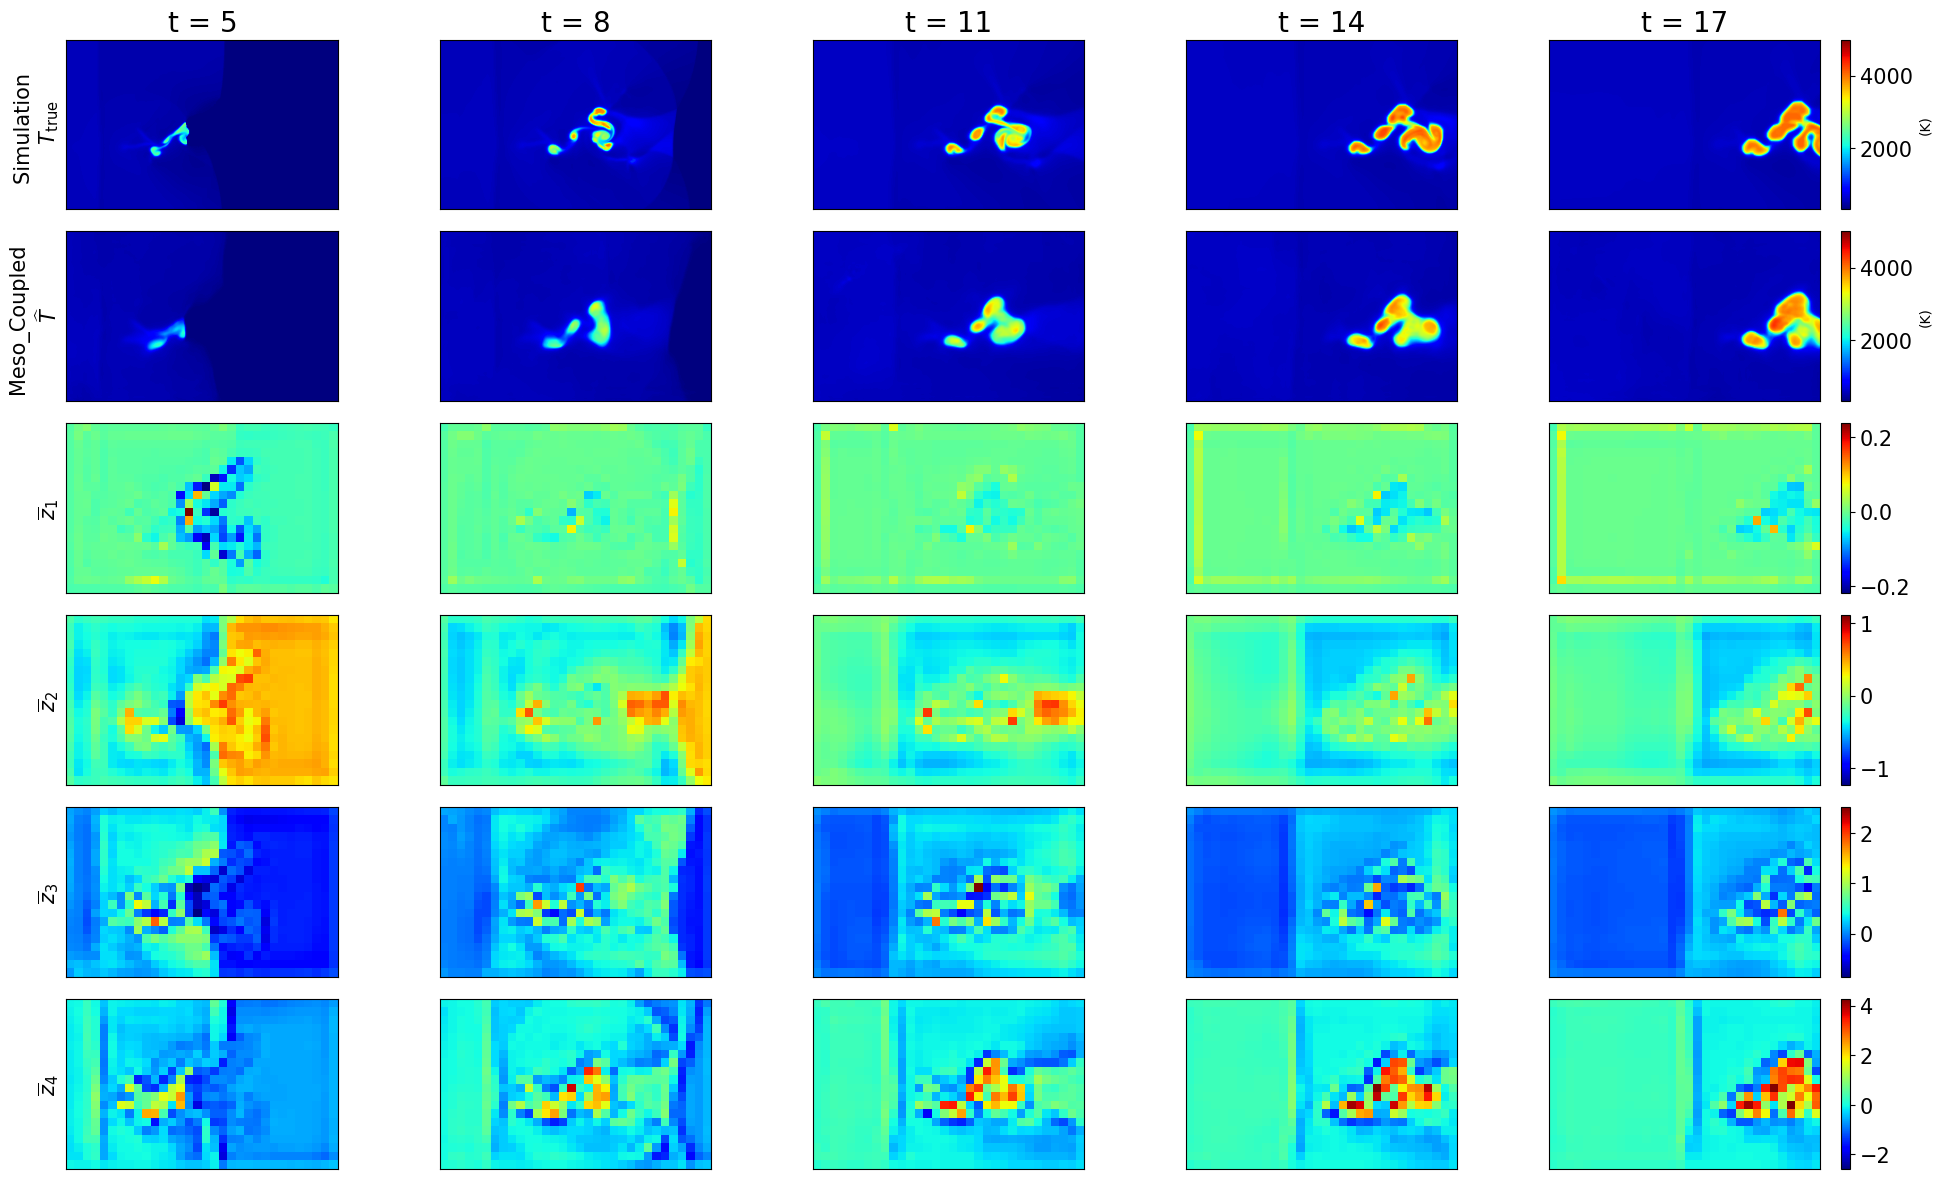

In [ ]:
# visualizing the predicted evolution of a physical field in comparison with its ground-truth,
# in addition to the corresponding evolution of the latent-mean (or latent-log-variance) field in latent space.

fig = plot_pred_field(x, z, t0=5, ts=3, field_idx=field_idx, spatial_scale='micro', mean_var='mean', n_rows=6)